In [ ]:
# Importation des modules et modèles 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, VarianceThreshold, RFECV, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
import warnings
import os
import s3fs
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN

warnings.filterwarnings("ignore")

# On crée un bucket pour pouvoir récupérer les données sur le serveur
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET = "..."

# On fixe un random state pour toute la suite du code, pour garantir la reproductibilité des résultats
RANDOM_STATE = 42

In [ ]:
# On crée une fonction pour charger les données
def load_data(file_key):
    file_path_s3 = f"{BUCKET}/{file_key}"
    try:
        with fs.open(file_path_s3, mode="rb") as file_in:
            df = pd.read_csv(file_in, sep=",")
        return df
    except Exception as e:
        print(f"Error loading {file_key}: {e}")
        return pd.DataFrame()  

train_home_team = load_data("train_home_team_statistics_df.csv")
train_away_team = load_data("train_away_team_statistics_df.csv")
train_home_player = load_data("train_home_player_statistics_df.csv")
train_away_player = load_data("train_away_player_statistics_df.csv")
train_scores = load_data("Y_train.csv")

test_home_team = load_data("test_home_team_statistics_df.csv")
test_away_team = load_data("test_away_team_statistics_df.csv")
test_home_player = load_data("test_home_player_statistics_df.csv")
test_away_player = load_data("test_away_player_statistics_df.csv")

In [250]:
#On rajoute des préfixes HOME_ et AWAY_ devant les colonnes et les on ajoute dans un même dataset pour les teams pour distinguer
def prefix_columns(df, prefix):
    df = df.rename(columns={col: f"{prefix}_{col}" if col != 'ID' else col for col in df.columns})
    return df

#On ajoute les préfixes
train_home_team_prefixed = prefix_columns(train_home_team, 'HOME')
train_away_team_prefixed = prefix_columns(train_away_team, 'AWAY')

#On merge selon ID
train_team = pd.merge(train_home_team_prefixed, train_away_team_prefixed, on='ID', how='inner')


In [251]:
#On aggrège les statistiques des joueurs pour chaque colonne en faisant la moyenne des stats des joueurs de chaque équipe
def aggregate_player_stats(df, prefix):
    season_total_columns = [col for col in df.columns if col.endswith('_season_sum')]
        
    team_stats = df.groupby('ID')[season_total_columns].agg(['mean', 'max', 'std']).reset_index()
        
    team_stats.columns = ['ID'] + [f"{prefix}_{col[0]}_{col[1]}" for col in team_stats.columns[1:]]
    return team_stats



#On applique notre fonction au home et away
train_home_player_agg = aggregate_player_stats(train_home_player, 'HOME')
train_away_player_agg = aggregate_player_stats(train_away_player, 'AWAY')



In [252]:
#Enfin, on aggrège toutes les données pour avoir une base de données train, en se basant sur ID

train_data = train_team.merge(train_home_player_agg, on='ID', how='inner').merge(train_away_player_agg, on='ID', how='inner')

In [253]:
#On transforme les variables catégorielles en une seule  variable numérique via un mapping pour pouvoir avoir une colonne target

train_scores['target'] = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
target_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores['target'] = train_scores['target'].map(target_mapping)
y = train_scores['target']

#On retire les colonnes inutiles
train_data = train_data.drop(['HOME_LEAGUE', 'HOME_TEAM_NAME', 'AWAY_LEAGUE', 'AWAY_TEAM_NAME'], axis=1)


In [254]:
ids = train_data['ID'].copy()
train_data = train_data.drop('ID', axis=1)
train_data = train_data.dropna(axis=1, how='all')


In [ ]:
def add_features(df):

    import numpy as np
    import pandas as pd
    
    # On convertit le df en DataFrame si ce n'est pas déjà le cas
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
    else:
        df = df.copy()
    
    # Fonction utilitaire pour diviser deux valeurs en toute sécurité
    def safe_div(a, b):
        return np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    
    # HFonction utilitaire pour vérifier si un DataFrame contient certaines colonnes
    def has_columns(required_cols):
        return all(col in df.columns for col in required_cols)
    

    if has_columns(['HOME_TEAM_GOALS_season_sum', 'AWAY_TEAM_GOALS_season_sum']):
        df['GOALS_DIFFERENCE'] = df['HOME_TEAM_GOALS_season_sum'] - df['AWAY_TEAM_GOALS_season_sum']
    
    if has_columns(['HOME_TEAM_GAME_WON_5_last_match_sum', 'AWAY_TEAM_GAME_WON_5_last_match_sum']):
        df['FORM_DIFFERENCE'] = df['HOME_TEAM_GAME_WON_5_last_match_sum'] - df['AWAY_TEAM_GAME_WON_5_last_match_sum']
    
    if has_columns(['HOME_TEAM_SHOTS_ON_TARGET_season_sum', 'HOME_TEAM_GOALS_season_sum']):
        df['HOME_CONVERSION_RATE'] = safe_div(
            df['HOME_TEAM_GOALS_season_sum'],
            df['HOME_TEAM_SHOTS_ON_TARGET_season_sum']
        )
    
    if has_columns(['AWAY_TEAM_SHOTS_ON_TARGET_season_sum', 'AWAY_TEAM_GOALS_season_sum']):
        df['AWAY_CONVERSION_RATE'] = safe_div(
            df['AWAY_TEAM_GOALS_season_sum'],
            df['AWAY_TEAM_SHOTS_ON_TARGET_season_sum']
        )
    
    if has_columns(['HOME_TEAM_BALL_POSSESSION_season_average', 'AWAY_TEAM_BALL_POSSESSION_season_average']):
        df['POSSESSION_DOMINANCE'] = df['HOME_TEAM_BALL_POSSESSION_season_average'] - df['AWAY_TEAM_BALL_POSSESSION_season_average']
    
    return df

In [ ]:
# On fait un train test split, en prenant en compte la stratification pour avoir des classes équilibrées
X_train, X_test, y_train, y_test = train_test_split(
    train_data, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


Class Distribution:
target
0    0.435341
2    0.305698
1    0.258961
Name: proportion, dtype: float64


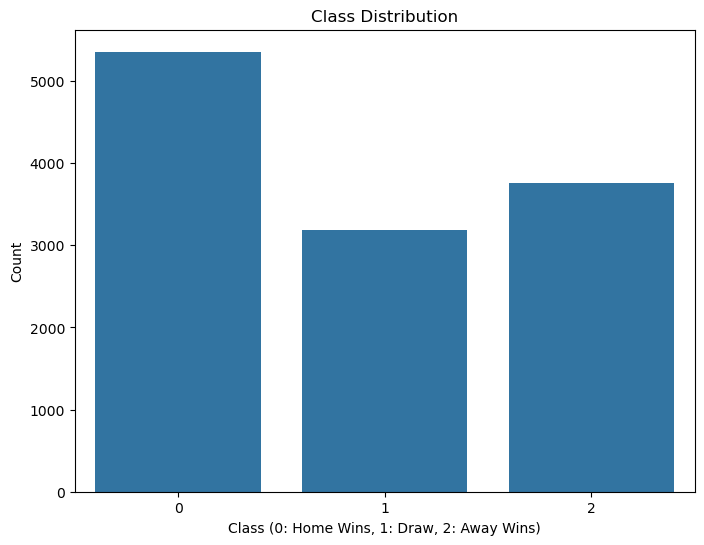

In [ ]:
# On plot la distribution des classes ==> On voit qu'il y a un déséquilibre entre les classes
print("\nClass Distribution:")
class_dist = pd.Series(y).value_counts(normalize=True)
print(class_dist)


plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Class (0: Home Wins, 1: Draw, 2: Away Wins)')
plt.ylabel('Count')
plt.show()

In [ ]:
# On affiche les premières lignes de notre dataset pour vérifier que l'aggrégation a bien été faite et voir le nombre de colonnes
X_train.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_PLAYER_TOTAL_CROSSES_season_sum_std,AWAY_PLAYER_TOTAL_DUELS_season_sum_mean,AWAY_PLAYER_TOTAL_DUELS_season_sum_max,AWAY_PLAYER_TOTAL_DUELS_season_sum_std,AWAY_PLAYER_YELLOWCARDS_season_sum_mean,AWAY_PLAYER_YELLOWCARDS_season_sum_max,AWAY_PLAYER_YELLOWCARDS_season_sum_std,AWAY_PLAYER_PUNCHES_season_sum_mean,AWAY_PLAYER_PUNCHES_season_sum_max,AWAY_PLAYER_PUNCHES_season_sum_std
7157,5.0,4.0,7.0,4.0,4.0,4.0,3.0,1.0,6.0,6.0,...,25.349324,34.444444,81.0,24.088616,22.055556,75.0,25.243455,NaN,NaN,NaN
773,7.0,5.0,8.0,3.0,4.0,4.0,3.0,6.0,6.0,4.0,...,9.860050,32.588235,87.0,28.911630,17.411765,50.0,17.135704,NaN,NaN,NaN
6085,6.0,5.0,5.0,7.0,5.0,10.0,10.0,10.0,10.0,3.0,...,19.056915,27.434783,71.0,20.426868,19.347826,50.0,18.034333,NaN,NaN,NaN
6011,10.0,9.0,7.0,7.0,7.0,10.0,10.0,4.0,9.0,4.0,...,10.826333,24.260870,97.0,24.119433,19.130435,80.0,22.138622,0.782609,18.0,3.753259
7065,6.0,4.0,6.0,6.0,8.0,9.0,10.0,6.0,6.0,4.0,...,16.407605,29.478261,75.0,20.740539,23.043478,80.0,22.245486,1.913043,44.0,9.174634


In [ ]:
# Transformateur pour ajouter des features engineered avec la fonction add_features
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return add_features(X)

In [ ]:
#Transformateur qui permet d'imputer les valeurs manquantes tout en gardant le format DataFrame
class DataFramePreservingImputer(SimpleImputer):
    def fit_transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
            arr = super().fit_transform(X)
            return pd.DataFrame(arr, columns=self.columns_)
        return super().fit_transform(X)
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            arr = super().transform(X)
            return pd.DataFrame(arr, columns=self.columns_)
        return super().transform(X)

In [ ]:
# On crée un transformateur pour sélectionner les features les plus importantes quand on lui passe un modèle (modèles d'arbres), avec des logs pour suivre le processus
class ModelBasedFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, k_features=None):
        self.estimator = estimator 
        self.k_features = k_features
        self.selected_features = None
        self.feature_names = None
        self.feature_importances_ = None
        
    def fit(self, X, y=None):
        try:
            if isinstance(X, np.ndarray):
                X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
            
            self.feature_names = X.columns.tolist()
            print(f"ModelBasedFeatureSelector: Starting feature selection with {len(self.feature_names)} features")
            
            if self.estimator is None:
                self.estimator = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE) # On choisit un RandomForest par défaut
            
            self.estimator.fit(X, y) # On fit le modèle pour récupérer les feature importances
            

            if hasattr(self.estimator, 'feature_importances_'):
                self.feature_importances_ = self.estimator.feature_importances_
            else:
                print("Using mutual_info_classif for feature importance")
                self.feature_importances_ = mutual_info_classif(X, y, random_state=RANDOM_STATE) 
            

            if self.k_features is None:
                self.k_features = int(0.3 * X.shape[1]) # On choisit 30% des features (mieux trouvé en faisant des tests)
            

            feature_importance_pairs = list(zip(self.feature_names, self.feature_importances_)) # On crée une liste de paires (feature, importance)
            sorted_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True) # On trie les paires par importance
            

            self.selected_features = [pair[0] for pair in sorted_pairs[:self.k_features]] 
            
            print(f"ModelBasedFeatureSelector: Selected {len(self.selected_features)} features out of {len(self.feature_names)}")
            print("Top 5 selected features and their importance scores:")
            for feature, importance in sorted_pairs[:5]:
                print(f"- {feature}: {importance:.4f}")
            
            return self
            
        except Exception as e:
            print(f"Error in ModelBasedFeatureSelector.fit: {str(e)}")
            self.selected_features = self.feature_names
            return self
        
    def transform(self, X):
        if self.selected_features is None:
            print("Warning: No features were selected, returning original data")
            return X
            
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        
        print(f"Transforming data from {X.shape[1]} to {len(self.selected_features)} features")
        return X[self.selected_features]
    
    def get_feature_names_out(self, feature_names=None):
        return np.array(self.selected_features)


In [ ]:
#Grilles de paramètres ajustées pour chaque modèle au cours de différents tests
xgb_param_space = {
    'model__n_estimators': Integer(100, 1000),
    'model__max_depth': Integer(3, 10),
    'model__learning_rate': Real(0.001, 0.3, prior='log-uniform'),
    'model__subsample': Real(0.6, 1.0),
    'model__colsample_bytree': Real(0.6, 1.0),
    'model__min_child_weight': Integer(1, 10),
    'model__gamma': Real(0.0, 0.5),
    'model__reg_alpha': Real(0.1, 5.0),  
    'model__reg_lambda': Real(1.0, 10.0)  
}

rf_param_space = {
    'model__n_estimators': Integer(100, 500),
    'model__max_depth': Integer(5, 30),
    'model__min_samples_split': Integer(2, 50),
    'model__min_samples_leaf': Integer(1, 10),
    'model__max_features': Categorical(['sqrt', 'log2', None])
}

lgb_param_space = {
    'model__n_estimators': Integer(50, 2000),
    'model__learning_rate': Real(0.001, 0.5, prior='log-uniform'),
    'model__max_depth': Integer(2, 15),
    'model__num_leaves': Integer(10, 500),
    'model__min_child_samples': Integer(5, 200),
    'model__subsample': Real(0.5, 1.0),
    'model__colsample_bytree': Real(0.5, 1.0),
    'model__reg_alpha': Real(0, 5.0),
    'model__reg_lambda': Real(0, 5.0),
    'model__min_child_weight': Real(0.001, 1.0),
    'model__min_split_gain': Real(0.0, 0.1),
    'model__min_data_in_leaf': Integer(1, 50)
}


In [ ]:

# Création d'un pipeline pour chaque modèle
def create_model_pipeline(model, with_resampling=True):
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('feature_engineering', FeatureEngineeringTransformer()),
        ('variance', VarianceThreshold(threshold=0.02)),
        ('scaler', RobustScaler()),
        ('pca', PCA(n_components=0.95)),
        ('feature_selection', ModelBasedFeatureSelector(
            estimator=clone(model),
            k_features=None
        )),
    ]
    
    if with_resampling: # On ajoute un étape de resampling si with_resampling=True 

        total_samples = y.shape[0]  
        

        target_per_class = int(total_samples / 3) 
        
        steps.append(('resampling', SMOTEENN( # On utilise SMOTEENN pour le resampling, en gardant le même nombre d'échantillons pour chaque classe
            sampling_strategy={
                1: target_per_class,  
                2: target_per_class   
            },
            random_state=RANDOM_STATE,
            n_jobs=-1
        )))
    
    steps.append(('model', model))
    return ImbPipeline(steps) if with_resampling else Pipeline(steps) # On retourne un ImbPipeline si with_resampling=True, sinon un Pipeline


In [ ]:
#On initialise les modèles de base
base_models = [
    ('lgb', lgb.LGBMClassifier(
        objective='multiclass',
        num_class=3,
        random_state=RANDOM_STATE
    )),
    ('xgb', xgb.XGBClassifier(
        objective='multi:softprob', 
        num_class=3, 
        use_label_encoder=False, 
        eval_metric='mlogloss',
        random_state=RANDOM_STATE
    )),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
]

In [ ]:
# Fonction pour évaluer un modèle en affichant les résultats de base, à but comparatif (heatmap, classification report, etc.)
def evaluate_model(model, X, y, model_name):

    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    

    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'weighted_f1': f1_score(y, y_pred, average='weighted'),
        'macro_f1': f1_score(y, y_pred, average='macro'),
        'roc_auc': roc_auc_score(y, y_pred_proba, multi_class='ovr')
    }
    
    print(f"\n{model_name} Results:")
    for metric_name, score in metrics.items():
        print(f"{metric_name}: {score:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y, y_pred), 
                annot=True, 
                fmt='d',
                cmap='Blues',
                xticklabels=['Home', 'Draw', 'Away'],
                yticklabels=['Home', 'Draw', 'Away'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'metrics': metrics,
        'model': model
    }

#Fonction pour optimiser les hyperparamètres des modèles (Bayesian Optimization) avec un nombre important d'itérations pour optimiser au mieux les modèles
def bayesian_hyperparameter_tuning(model_name, model, param_space, X_train, y_train):

    print(f"Optimizing {model_name}...")
    
    pipeline = create_model_pipeline(model)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=RANDOM_STATE)
    

    scoring = {
        'accuracy': 'accuracy',
        'f1_weighted': 'f1_weighted',
        'f1_macro': 'f1_macro',
        'roc_auc_ovr': 'roc_auc_ovr'
    }
    
    search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space,
        n_iter=100,
        scoring=scoring,
        refit='f1_weighted',  
        cv=cv,
        verbose=1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    
    print(f"\nBest parameters for {model_name}:")
    print(search.best_params_)
    print("\nBest scores:")
    for metric, score in search.cv_results_.items():
        if metric.startswith('mean_test_'):
            metric_name = metric.replace('mean_test_', '')
            print(f"{metric_name}: {score[search.best_index_]:.4f}")
    
    return search.best_estimator_

In [ ]:
# On utilise un dictionnaire pour stocker les modèles optimisés
tuned_models = {}
param_spaces = {
    'lgb': lgb_param_space,
    'xgb': xgb_param_space,
    'rf': rf_param_space
}

for name, model in base_models:
    tuned_model = bayesian_hyperparameter_tuning(
        name, 
        model, 
        param_spaces[name], 
        X_train, 
        y_train
    )
    tuned_models[name] = tuned_model

Transforming data from 144 to 43 features
Transforming data from 144 to 43 features

lgb Results:
accuracy: 0.3560
weighted_f1: 0.3354
macro_f1: 0.3475
roc_auc: 0.5853

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.17      0.27      1072
           1       0.28      0.70      0.40       637
           2       0.44      0.33      0.38       752

    accuracy                           0.36      2461
   macro avg       0.45      0.40      0.35      2461
weighted avg       0.48      0.36      0.34      2461



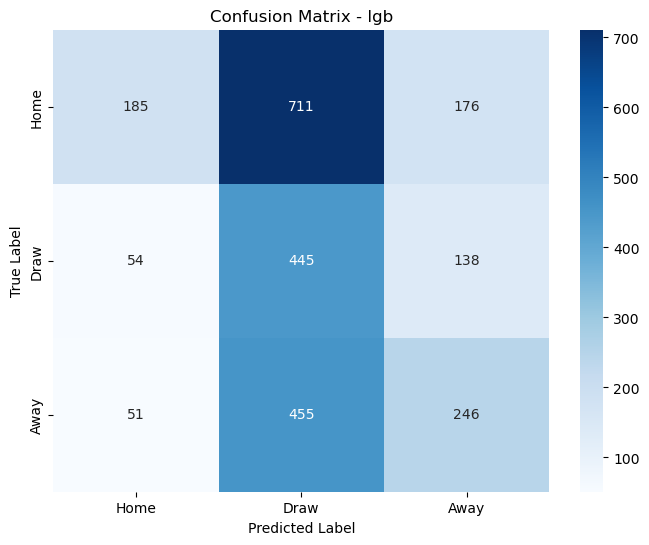

Transforming data from 144 to 43 features
Transforming data from 144 to 43 features

xgb Results:
accuracy: 0.3653
weighted_f1: 0.3541
macro_f1: 0.3605
roc_auc: 0.5903

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.21      0.32      1072
           1       0.28      0.67      0.39       637
           2       0.42      0.33      0.37       752

    accuracy                           0.37      2461
   macro avg       0.46      0.40      0.36      2461
weighted avg       0.50      0.37      0.35      2461



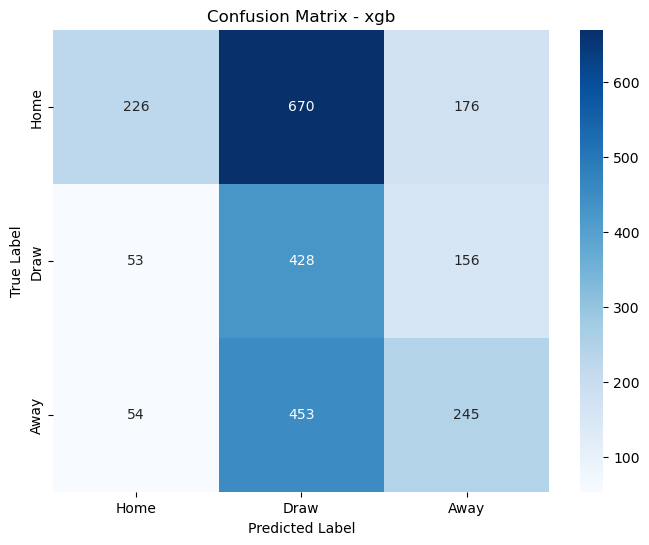

Transforming data from 144 to 43 features
Transforming data from 144 to 43 features

rf Results:
accuracy: 0.3507
weighted_f1: 0.3122
macro_f1: 0.3325
roc_auc: 0.6016

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.12      0.20      1072
           1       0.28      0.78      0.41       637
           2       0.48      0.32      0.39       752

    accuracy                           0.35      2461
   macro avg       0.49      0.41      0.33      2461
weighted avg       0.53      0.35      0.31      2461



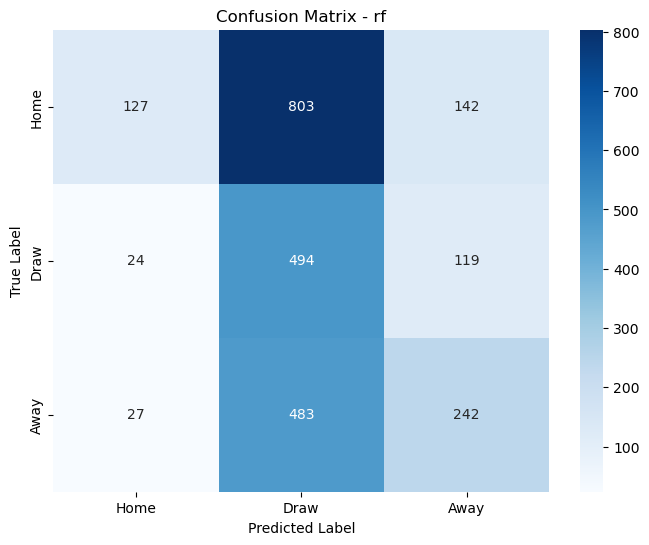

In [ ]:
# On évalue les modèles optimisés grâce à la fonction evaluate_model
model_metrics = {}
for name, model in tuned_models.items():
    model_metrics[name] = evaluate_model(model, X_test, y_test, name)

In [ ]:
# Création d'un modèle ensemble amélioré avec un stacking classifier, en ajoutant aussi différents modèles de base
def create_ensemble_model(base_models_dict):
    estimators = []
    
    scores = {name: model_data['metrics']['accuracy'] for name, model_data in base_models_dict.items()} 
    print("\nModel accuracies:")
    for name, score in scores.items():
        print(f"{name}: {score:.3f}")
    
    #Approche flexible pour pouvoir gérer modèles issues de pipeline classique, d'imbpipeline ou autre
    for name, model_data in base_models_dict.items():
        if hasattr(model_data['model'], 'named_steps'):
            base_model = model_data['model'].named_steps['model']
        elif hasattr(model_data['model'], 'steps'):
            base_model = model_data['model'].steps[-1][1]
        else:
            base_model = model_data['model']
            
        estimators.append((name, base_model))
    
    estimators.append(('lr', LogisticRegression(multi_class='ovr', random_state=RANDOM_STATE))) #On ajoute rég logistique et svm pour diversifier les modèles du stacking
    estimators.append(('svm', SVC(probability=True, random_state=RANDOM_STATE)))
    
    # Utilisation de la régression logistique comme modèle final (après plusieurs tests, c'est celui qui a donné les meilleurs résultats)
    final_estimator = LogisticRegression(
        multi_class='ovr',
        random_state=RANDOM_STATE,
        max_iter=1000
    )
    
    return StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=RANDOM_STATE),
        stack_method='predict_proba',
        n_jobs=-1
    )

In [ ]:
# Créer et évaluer le modèle d'ensemble
ensemble = create_ensemble_model(model_metrics)

# Créer une pipeline cohérent pour l'ensemble
ensemble_pipeline = Pipeline([
    ('imputer', DataFramePreservingImputer(strategy='median')),
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('variance', VarianceThreshold(threshold=0.01)),
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.95)),  # Add PCA here too
    ('model', ensemble)
])

# Entraîner le modèle d'ensemble
ensemble_pipeline.fit(X_train, y_train)

# Évaluer l'ensemble
ensemble_metrics = evaluate_model(ensemble_pipeline, X_test, y_test, "Ensemble")


In [ ]:
#On force le meilleur modèle à être l'ensemble
best_model_name = 'ensemble'
best_model = ensemble_metrics['model']



In [ ]:
# Réentraînement du meilleur modèle sur toutes les données
print(f"Retraining {best_model_name} on all data...")


final_pipeline = Pipeline([
    ('imputer', DataFramePreservingImputer(strategy='median')),
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('variance', VarianceThreshold(threshold=0.01)),
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.95)),  
    ('model', create_ensemble_model(model_metrics))
    ])


# Entraîner sur toutes les données avant de faire nos prédictions
final_pipeline.fit(train_data, y)

In [ ]:
# Préparation et prédiction des données de test, en s'assurant une consistency dans les méthodologies du prétraitement
def prepare_test_data():

    test_home_team_prefixed = prefix_columns(test_home_team, 'HOME')
    test_away_team_prefixed = prefix_columns(test_away_team, 'AWAY')
    

    test_team = pd.merge(test_home_team_prefixed, test_away_team_prefixed, on='ID', how='inner')
    

    test_home_player_agg = aggregate_player_stats(test_home_player, 'HOME')
    test_away_player_agg = aggregate_player_stats(test_away_player, 'AWAY')
    

    test_data = test_team.merge(test_home_player_agg, on='ID', how='inner').merge(test_away_player_agg, on='ID', how='inner')
    

    test_data = test_data.drop(['HOME_LEAGUE', 'HOME_TEAM_NAME', 'AWAY_LEAGUE', 'AWAY_TEAM_NAME'], axis=1, errors='ignore')
    

    test_ids = test_data['ID'].copy()
    test_data = test_data.drop('ID', axis=1)
    

    train_columns = train_data.columns.tolist()
    

    for col in train_columns:
        if col not in test_data.columns:
            test_data[col] = np.nan
    

    test_data = test_data[train_columns]
    

    assert list(test_data.columns) == list(train_data.columns), "Column mismatch after alignment"
    
    return test_data, test_ids

# Préparer les données de test
test_data, test_ids = prepare_test_data()

# Prédictions
test_predictions = final_pipeline.predict(test_data)
test_probabilities = final_pipeline.predict_proba(test_data)


In [280]:
# Création du fichier de soumission
submission = pd.DataFrame({
    'ID': test_ids,
    'HOME_WINS': (test_predictions == 0).astype(int),
    'DRAW': (test_predictions == 1).astype(int),
    'AWAY_WINS': (test_predictions == 2).astype(int)
})

submission_file = 'submission_finale.csv'
submission.to_csv(submission_file, index=False)
print(f"Submission file saved as {submission_file}")

Submission file saved as submission_finale.csv
